In [1]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
import astroquery.heasarc
from astropy.wcs import WCS
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib.patches import Circle
from astroquery.jplhorizons import Horizons
import pandas as pd
import astropy.units as u
import json

In [2]:
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Load the ScWs

In [3]:
scws = []
scw_start_times = []
scw_end_times = []

with open("../data/Crab-ScWs.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scws.append(parts[0])
        scw_start_times.append(float(parts[1]))  
        scw_end_times.append(float(parts[2]))  

unique_sorted_data = {}
for scw, start, end in sorted(zip(scws, scw_start_times, scw_end_times), key=lambda x: x[0]):
    if scw not in unique_sorted_data:  
        unique_sorted_data[scw] = (scw, start, end)

scws, scw_start_times, scw_end_times = map(list, zip(*unique_sorted_data.values()))

Pick a random ScW.

In [13]:
np.random.seed = 999
pick = np.random.randint(len(scws))
scw_pick = scws[pick]
start_pick = scw_start_times[pick]
end_pick = scw_end_times[pick]

## QUERYING 

In [14]:
disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

crab = SkyCoord.from_name("Crab")
ra = crab.ra.deg
dec = crab.dec.deg

par_dict = {
    "RA": ra,
    "DEC": dec,
    "E1_keV": "15",
    "E2_keV": "30",
    "T_format": "mjd",
    'T1': start_pick,
    'T2': end_pick,
    "detection_threshold": "5",
    "instrument": "isgri",
    "osa_version": "OSA11.2",
    "product": "isgri_image",
    "product_type": "Real",
    "scw_list": [scw_pick],
    'token': oda_api.token.discover_token()
}

data_collection = disp.get_product(**par_dict)
data_collection.show()

found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
token expires in 215.2 h
discovered token in environment
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
token expires in 215.2 h
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2025-03-16 14:19:42), please wait for https://ww

ID=0 prod_name=mosaic_image_0_mosaic  meta_data: {'product': 'mosaic', 'instrument': 'isgri', 'src_name': '', 'query_parameters': None}

ID=1 prod_name=dispatcher_catalog_1  meta_data: 



## IMAGING & ANALYSIS

Image analysis (extraction of count rates over time).

In [15]:
data_collection.mosaic_image_0_mosaic.show()
print(data_collection.mosaic_image_0_mosaic.show_meta())
data_collection.dispatcher_catalog_1.table

------------------------------
name: mosaic_image
meta_data dict_keys(['product', 'instrument', 'src_name', 'query_parameters'])
number of data units 6
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: GROUPING
data uniti 2 ,name: ISGR-MOSA-IMA
data uniti 3 ,name: ISGR-MOSA-IMA
data uniti 4 ,name: ISGR-MOSA-IMA
data uniti 5 ,name: ISGR-MOSA-IMA
------------------------------
product : mosaic
instrument : isgri
src_name : 
query_parameters : None
------------------------------
None


meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str4,float64,float64,float64,int64,int64,int64,float64
13,Crab,76.03929138183594,83.62815856933594,22.016250610351562,-32768,2,0,0.0002800000074785203


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57262.763796 from DATE-OBS.
Set MJD-END to 57262.784630 from DATE-END'. [astropy.wcs.wcs]
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/plot_tools.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


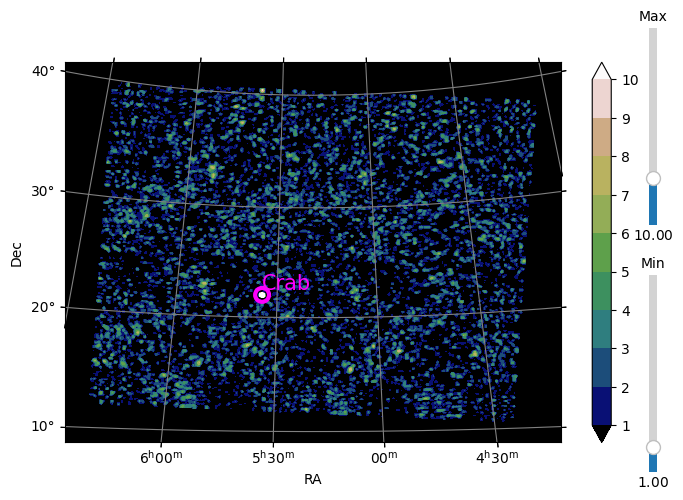

In [16]:
im=OdaImage(data_collection)
_ = im.show()
# im.write_fits(f"../data/Crab-{scw_pick}")

In [17]:
header = data_collection.mosaic_image_0_mosaic.get_data_unit(2).header
header

{'BASETYPE': 'DAL_ARRAY',
 'BITPIX': -32,
 'BSCALE': 1,
 'BUNIT': 'counts/sec',
 'BZERO': 0,
 'CD1_1': -0.0822862539155913,
 'CD1_2': 0.0,
 'CD2_1': 0.0,
 'CD2_2': 0.0822862539155913,
 'CHANMAX': 30,
 'CHANMIN': 15,
 'CHANTYPE': 'PI',
 'CHECKSUM': '1A48113618361836',
 'COMMENT': 'STAMP :',
 'CONFIGUR': 'osa_2021-08-27T14:27:00',
 'CREATOR': 'ii_skyimage 5.4.4',
 'CRPIX1': 212.0,
 'CRPIX2': 212.0,
 'CRVAL1': 79.7798614501953,
 'CRVAL2': 25.9460754394531,
 'CTYPE1': 'RA---TAN',
 'CTYPE2': 'DEC--TAN',
 'CUNIT1': 'deg',
 'CUNIT2': 'deg',
 'DATASUM': '1804026214',
 'DATE': '2025-03-16T13:28:20',
 'DATE-END': '2015-08-28T18:49:52',
 'DATE-OBS': '2015-08-28T18:19:52',
 'DEADC': 0.756684160550213,
 'DETNAM': 'ISGRI',
 'EQUINOX': 2000.0,
 'EXTNAME': 'ISGR-MOSA-IMA',
 'EXTREL': '7.4',
 'EXTVER': 1,
 'E_MAX': 30.0,
 'E_MEAN': 22.5,
 'E_MIN': 15.0,
 'GCOUNT': 1,
 'GRPID1': 1,
 'HDUCLAS1': 'IMAGE',
 'HDUCLASS': 'OGIP',
 'HDUDOC': 'ISDC-IBIS ICD',
 'HDUVERS': '1.1.0',
 'IMATYPE': 'INTENSITY',
 'INST

In [18]:
data_unit = data_collection.mosaic_image_0_mosaic.get_data_unit(2)  
header = data_collection.mosaic_image_0_mosaic.get_data_unit(2).header
image_data = data_unit.data 
wcs = WCS(header) 

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57262.763796 from DATE-OBS.
Set MJD-END to 57262.784630 from DATE-END'. [astropy.wcs.wcs]


Countrate to flux conversion (method of E. Jourdain using ISGRI calibration).

Crab count rate: 171.93973 counts/sec
Analytically calculated photon flux: 0.2501898870399915 ph/cm2/s
Numerically calculated photon flux: 0.2502236796064092 ph/cm2/s
Numerically calculated energy flux: 8.296223349642631e-09 erg/cm2/s
Flux per count = energy per photon: 3.315522880445298e-08 erg/photon

To convert countrate to flux, multiply countrate by flux per count: 
Conversion factor: 0.0014552988005303428 for ph/cm2/s or 4.8250764710429494e-11 for erg/cm2/s


Text(0, 0.5, 'Flux ($ph.cm^{-2}.s^{-1}/keV$)')

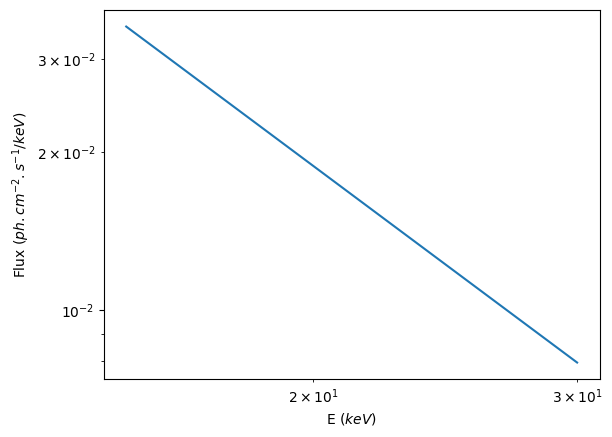

In [19]:
E0 = 100 # 100 keV reference energy
K = 6.2e-4 # flux @ 100 keV (photons/cm2/s), roughly the same for each instrument
E = np.linspace(15, 30)
gamma = 2.12 # photon index of ISGRI (2.105 for SPI+ISGRI+JEM-X)

power_law = K * (E/E0)**(-gamma) # flux

x, y = wcs.all_world2pix(ra, dec, 0)
x_int, y_int = int(round(x.item())), int(round(y.item()))

crab_countrate = image_data[y_int, x_int]

print("Crab count rate:", crab_countrate, "counts/sec")

ph_flux = - K * (E0)**(gamma) / (gamma-1) * ((30)**(1-gamma) - (15)**(1-gamma)) # analytic
ph_flux_num = np.trapz(power_law, E) # numeric
ph_flux_num_erg = np.trapz(power_law*E*1.60218e-9, E) # numeric, energy units

print(f'Analytically calculated photon flux: {ph_flux} ph/cm2/s')
print(f'Numerically calculated photon flux: {ph_flux_num} ph/cm2/s')
print(f'Numerically calculated energy flux: {ph_flux_num_erg} erg/cm2/s')
print(f'Flux per count = energy per photon: {ph_flux_num_erg/ph_flux_num} erg/photon')
print('\nTo convert countrate to flux, multiply countrate by flux per count:',
      f'\nConversion factor: {ph_flux_num/crab_countrate} for ph/cm2/s or {ph_flux_num_erg/crab_countrate} for erg/cm2/s')

plt.figure()
plt.loglog(E, power_law)
plt.xlabel('E ($keV$)')
plt.ylabel('Flux ($ph.cm^{-2}.s^{-1}/keV$)')

Analysis from fits file.

In [ ]:
fits_file = f"../data/Crab-{scw_pick}"+"mosaic.fits"

pick = 2  # 2 for image, 3 for variance, 4 for significance and 5 for exposure map

with fits.open(fits_file) as hdul:
    hdul.info()
    intensity_data = hdul[2].data 
    variance_data = hdul[3].data
    significance_data = hdul[4].data
    exposure_data = hdul[5].data
    #print("\n")
    #print(repr(hdul[pick].header))
    #print("\n")
    #print(hdul[1].data.columns)
    wcs = WCS(hdul[pick].header)  
    CD1 = np.abs(hdul[pick].header["CD1_1"])

data = [intensity_data, variance_data, significance_data, exposure_data]
image_data = data[pick-2]


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower', aspect='auto')

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

x, y = wcs.all_world2pix(ra, dec, 0)

pixel_scale = CD1 * 3600  # pixel size in arcseconds (|CD1_1| from fits header)
circle_radius_pixels = 7 * 60 / pixel_scale / 2 

circle = Circle((x, y), circle_radius_pixels, edgecolor='black', facecolor='none', lw = 0.5)
ax.add_patch(circle)

ax.annotate(
        text="Crab", 
        xy=(x, y),  
        xytext=(x - 100, y + 150),
        arrowprops=dict(arrowstyle="->", color="black", lw=0.5),
        fontsize=11,
        color="black"
    )

title = ""
if pick == 2:
    title = "Intensity"
elif pick == 3:
    title = "Variance"
elif pick == 4:
    title = "Significance"
elif pick == 5:
    title = "Exposure"

plt.title(title+" map")
plt.colorbar(im, label="Intensity")

#plt.savefig(f"../data/Crab-{scw_pick}"+"_"+f"{title}.pdf", format='pdf', bbox_inches='tight')

Crab count rate: 167.69402 counts/sec
Analytically calculated photon flux: 0.2501898870399915 ph/cm2/s
Numerically calculated photon flux: 0.2502236796064092 ph/cm2/s
Numerically calculated energy flux: 8.296223349642631e-09 erg/cm2/s
Flux per count = energy per photon: 3.315522880445298e-08 erg/photon

To convert countrate to flux, multiply countrate by flux per count: 
Conversion factor: 0.0014921443610015866 for ph/cm2/s or 4.947238769828189e-11 for erg/cm2/s


Text(0, 0.5, 'Flux ($ph.cm^{-2}.s^{-1}/keV$)')

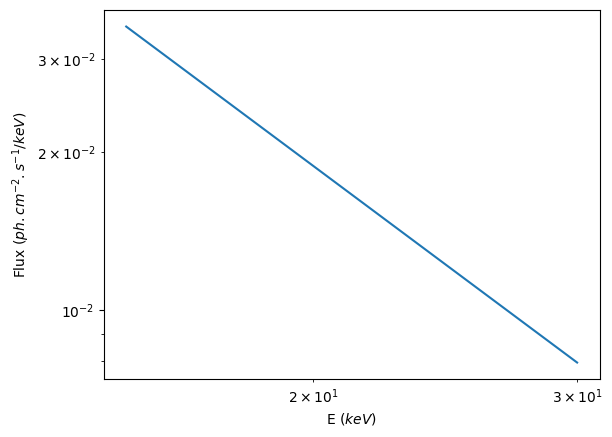

In [60]:
E0 = 100 # 100 keV reference energy
K = 6.2e-4 # flux @ 100 keV (photons/cm2/s), roughly the same for each instrument
E = np.linspace(15, 30)
gamma = 2.12 # photon index of ISGRI (2.105 for SPI+ISGRI+JEM-X)

power_law = K * (E/E0)**(-gamma) # flux

x_int, y_int = int(round(x.item())), int(round(y.item()))

crab_countrate = intensity_data[y_int, x_int]

print("Crab count rate:", crab_countrate, "counts/sec")

ph_flux = - K * (E0)**(gamma) / (gamma-1) * ((30)**(1-gamma) - (15)**(1-gamma)) # analytic
ph_flux_num = np.trapz(power_law, E) # numeric
ph_flux_num_erg = np.trapz(power_law*E*1.60218e-9, E) # numeric, energy units

print(f'Analytically calculated photon flux: {ph_flux} ph/cm2/s')
print(f'Numerically calculated photon flux: {ph_flux_num} ph/cm2/s')
print(f'Numerically calculated energy flux: {ph_flux_num_erg} erg/cm2/s')
print(f'Flux per count = energy per photon: {ph_flux_num_erg/ph_flux_num} erg/photon')
print('\nTo convert countrate to flux, multiply countrate by flux per count:',
      f'\nConversion factor: {ph_flux_num/crab_countrate} for ph/cm2/s or {ph_flux_num_erg/crab_countrate} for erg/cm2/s')

plt.figure()
plt.loglog(E, power_law)
plt.xlabel('E ($keV$)')
plt.ylabel('Flux ($ph.cm^{-2}.s^{-1}/keV$)')